### SE-ResNet50 

SE-ResNet의 네트워크 구조

<img src="" width="600" height="300">

### Import

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
from torchvision.models import ResNet

### Model

In [6]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y

class SEResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, reduction_ratio=16):
        super(SEResNetBlock, self).__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.se_block = SEBlock(out_channels, reduction_ratio)

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.se_block(x)
        return x

In [12]:
class SEResNet(nn.Module):
    def __init__(self, num_classes, block, layers, reduction_ratio=16):
        super(SEResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1, reduction_ratio=reduction_ratio)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2, reduction_ratio=reduction_ratio)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2, reduction_ratio=reduction_ratio)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2, reduction_ratio=reduction_ratio)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride, reduction_ratio):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, reduction_ratio))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1, reduction_ratio=reduction_ratio))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def seresnet50(num_classes=10, reduction_ratio=16):
    return SEResNet(num_classes, SEResNetBlock, [3, 4, 6, 3], reduction_ratio)

# 모델 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = seresnet50().to(device)

In [14]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
AdaptiveAvgPool2d-10             [-1, 64, 1, 1]               0
           Linear-11                    [-1, 4]             260
             ReLU-12                    [-1, 4]               0
           Linear-13                   [-1, 64]             320
          Sigmoid-14                   

In [8]:
#Dataset
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


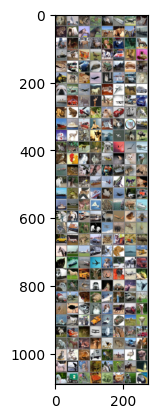

dog   ship  frog  deer  dog   truck plane cat   frog  dog   horse horse horse deer  horse ship  truck deer  horse deer  dog   cat   deer  horse ship  horse plane bird  horse car   deer  cat   frog  truck car   cat   frog  plane car   horse truck deer  dog   plane cat   ship  ship  dog   dog   deer  plane horse dog   plane horse car   ship  car   deer  deer  deer  plane truck car   dog   frog  plane deer  dog   car   ship  horse ship  ship  ship  dog   dog   deer  cat   truck ship  deer  bird  cat   ship  plane dog   bird  cat   frog  deer  deer  dog   plane bird  plane bird  bird  cat   dog   ship  frog  cat   bird  ship  frog  cat   cat   frog  ship  cat   frog  horse deer  plane ship  plane frog  dog   dog   ship  frog  cat   ship  cat   plane truck truck ship  plane deer  plane frog  dog   frog  ship  horse dog   truck ship  dog   plane frog  frog  bird  ship  deer  horse plane deer  deer  frog  car   plane frog  car   cat   cat   truck bird  horse plane plane truck deer  frog  ship

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
from tqdm import tqdm

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

num_epoch = 10
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

#Train
loss_arr = []
accuracy_arr = []

for i in range(num_epoch):

    total_accuracy = 0.0

    for j,[image,label] in enumerate(tqdm(trainloader, desc=f'Epoch {i+1}/{num_epoch}')):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, y_)
        total_accuracy += batch_accuracy

    avg_accuracy = total_accuracy / len(trainloader)
    accuracy_arr.append(avg_accuracy)

    print(f'Epoch {i+1}/{num_epoch}, Loss: {loss}, Train Accuracy: {avg_accuracy * 100:.2f}%')
    loss_arr.append(loss.cpu().detach().numpy())

model_path = 'SEResNet50.pth'

torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_arr,
    }, model_path)

Epoch 1/10: 100%|██████████| 196/196 [00:29<00:00,  6.56it/s]


Epoch 1/10, Loss: 1.5314557552337646, Train Accuracy: 32.05%


Epoch 2/10: 100%|██████████| 196/196 [00:29<00:00,  6.55it/s]


Epoch 2/10, Loss: 1.2685118913650513, Train Accuracy: 51.31%


Epoch 3/10: 100%|██████████| 196/196 [00:30<00:00,  6.51it/s]


Epoch 3/10, Loss: 1.1115015745162964, Train Accuracy: 60.81%


Epoch 4/10: 100%|██████████| 196/196 [00:30<00:00,  6.44it/s]


Epoch 4/10, Loss: 1.1367557048797607, Train Accuracy: 65.66%


Epoch 5/10: 100%|██████████| 196/196 [00:30<00:00,  6.50it/s]


Epoch 5/10, Loss: 0.8645910024642944, Train Accuracy: 69.62%


Epoch 6/10: 100%|██████████| 196/196 [00:30<00:00,  6.50it/s]


Epoch 6/10, Loss: 0.7837961912155151, Train Accuracy: 72.68%


Epoch 7/10: 100%|██████████| 196/196 [00:30<00:00,  6.52it/s]


Epoch 7/10, Loss: 0.6512200832366943, Train Accuracy: 75.44%


Epoch 8/10: 100%|██████████| 196/196 [00:30<00:00,  6.48it/s]


Epoch 8/10, Loss: 0.7377346754074097, Train Accuracy: 77.52%


Epoch 9/10: 100%|██████████| 196/196 [00:30<00:00,  6.48it/s]


Epoch 9/10, Loss: 0.6442177295684814, Train Accuracy: 79.50%


Epoch 10/10: 100%|██████████| 196/196 [00:30<00:00,  6.49it/s]


Epoch 10/10, Loss: 0.6451613306999207, Train Accuracy: 81.47%


In [18]:
model_path = 'SE-ResNet50.pth'

model = seresnet50().to(device)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

acc = []

with torch.no_grad():
    for image, label in testloader:
        x = image.to(device)
        y_ = label.to(device)
        output = model(x)
        
        _, predicted = torch.max(output, 1)
        accuracy = (predicted == y_).sum().item() / len(y_)
        acc.append(accuracy)
    print(f'Test Accuracy: {max(acc) * 100:.2f}%')

Test Accuracy: 81.25%
